# Graphillion Search for Psi_k

This notebook uses  to manage and search the space of triangle-free graphs on $ vertices.

We specifically search for graphs satisfying **Corollary 4** from the README, which equates property $\Psi_k$ (for  \le 3$) to:
1.  Every independent set of size $\le k$ has a common neighbor.
2.  The graph is twin-free ((x) \neq N(y)$).
3.  The graph is not isomorphic to a cycle {3m-1}$.

In [2]:
# Install graphillion if not present
!pip install graphillion

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import sys
import pickle
from graphillion import GraphSet

# Ensure local scripts can be imported
sys.path.append(".")

try:
    from find_triangle_free import generate_triangle_free_graphs, is_independent_set
    print("Successfully imported modules.")
except ImportError:
    print("Error: Could not import 'find_triangle_free.py'.")

Successfully imported modules.


## Property Checkers

We implement the conditions of Corollary 4.

In [4]:
def check_corollary_4(G, k):
    """
    Checks if G satisfies Corollary 4 conditions for Psi_k.
    
    1. Every IS of size <= k has a common neighbor.
    2. Twin-free.
    3. Not C_{3m-1}.
    """
    n = G.number_of_nodes()
    
    # Condition 3: Not isomorphic to C_{3m-1}
    # Check if n = 3m - 1 => n + 1 is divisible by 3.
    if (n + 1) % 3 == 0:
        # Check if G is a cycle
        # A connected 2-regular graph is a cycle.
        # Simplest check: Is it isomorphic to C_n?
        if nx.is_isomorphic(G, nx.cycle_graph(n)):
            return False
            
    # Condition 2: Twin-free
    # N(x) != N(y) for all distinct x, y
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            u, v = nodes[i], nodes[j]
            # Note: two vertices are 'twins' if they have the same neighbors.
            # (False twins if non-adjacent, True twins if adjacent).
            # The condition usually implies open neighborhoods.
            if set(G.neighbors(u)) == set(G.neighbors(v)):
                return False
    
    # Condition 1: Common neighbor for IS of size <= k
    # We check for sizes 1 to k.
    for size in range(1, k + 1):
        for subset in itertools.combinations(nodes, size):
            if is_independent_set(G, subset):
                # Check for common neighbor
                common = set(G.nodes())
                for node in subset:
                    common &= set(G.neighbors(node))
                
                if not common:
                    # Found an IS with no common neighbor
                    return False
                    
    return True

## GraphSet Creation and Search

We use  to store the universe of triangle-free graphs and filter them.

In [9]:
# Configuration
search_N = 8  # Graph size
search_k = 4   # Property Psi_k parameter

print(f"Setting up universe for N={search_N}...")
# Universe: All edges of K_N
universe_edges = list(nx.complete_graph(search_N).edges())
GraphSet.set_universe(universe_edges)

print(f"Generating triangle-free graphs of size {search_N}...")
# Generate graphs using the existing optimized backtracking script
tf_graphs_nx = list(generate_triangle_free_graphs(search_N))
print(f"Generated {len(tf_graphs_nx)} triangle-free graphs.")

# Convert to edge lists for Graphillion
tf_edge_lists = [list(G.edges()) for G in tf_graphs_nx]

print("Creating GraphSet (ZDD)...")
gs = GraphSet(tf_edge_lists)
print(f"GraphSet created. Size: {len(gs)}")

print(f"Filtering for Psi_{search_k} (Corollary 4)...")
matches = []
count = 0

for edges in gs:
    count += 1
    # Reconstruct graph for property check
    G = nx.Graph()
    G.add_nodes_from(range(search_N))
    G.add_edges_from(edges)
    
    if check_corollary_4(G, search_k):
        matches.append(G)
        
print(f"Found {len(matches)} graphs satisfying the property.")

Setting up universe for N=8...
Generating triangle-free graphs of size 8...
Generated 4682270 triangle-free graphs.
Creating GraphSet (ZDD)...
GraphSet created. Size: 4682270
Filtering for Psi_4 (Corollary 4)...
Found 2520 graphs satisfying the property.


Saved results to results_N8_k3.pkl


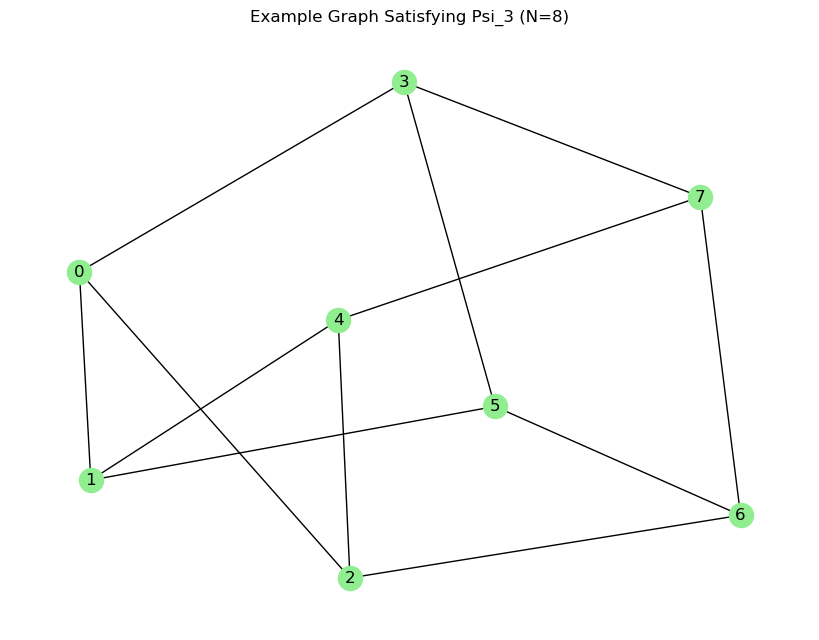

In [8]:
# Save Results
filename = f"results_N{search_N}_k{search_k}.pkl"
with open(filename, "wb") as f:
    pickle.dump(matches, f)
print(f"Saved results to {filename}")

# Visualize first match
if matches:
    plt.figure(figsize=(8, 6))
    nx.draw(matches[0], with_labels=True, node_color="lightgreen", edge_color="black")
    plt.title(f"Example Graph Satisfying Psi_{search_k} (N={search_N})")
    plt.show()